In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np

from datetime import datetime
import torchvision.models as models
import networks.load as load


import sys 
sys.path.append('..')
from utils_gsp.logger import Logger
# from utils_gsp import sps_tools
from gsp_model import GSP_Model
import utils_gsp.gsp_general as gsp_gen
import tools.ipynb_funcs as utilfuncs
import tools.visualization as viz

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import datasets.dataprep as dataprep
import networks.torch_vgg as pt_vgg
import networks.resnet as resnet

from main import train, validate, accuracy, save_checkpoint, setup_experiment, gsp_sparse_training, AverageMeter

In [5]:
class Args:
    arch = 'vgg16'
    dataset='cifar10'
    workers = 4
    epochs=160
    start_epoch=0
    batch_size = 128
    lr = 0.1
    momentum = 0.9
    weight_decay=1e-4
    print_freq = 50
    resume = False
    evaluate = False
    pretrained = False
    half = False
    exp_name = 'gsp_test'

    gpu=None
    logdir = '/logdir'
    gsp_training = True 
    gsp_sps = 0.8
    scheduled_sps_run = True
    proj_filters = False
    proj_model = False
    gsp_int = 150
    gsp_start_ep = -1
    finetune = False
    finetune_sps = 0.9


global args, best_acc1
args = Args
# writer = SummaryWriter()

In [8]:
# def sparsity_schedule(epoch, start_sps< end_sps):

np.linspace(0.4, 0.85, 10)


# to find the exponential scaling coefficient
x = 1 #



In [24]:
start=0.4
final=0.9
samples=100

# def exp_sps(start=0.4, final=0.9, samples=100):

translation = (1 - start)
scale_coeff = np.log(final + translation)/x
exp_sps_l = np.exp(x * scale_coeff) - translation
    # return exp_sps_l


In [38]:
translation

0.6

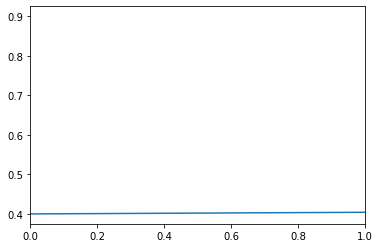

In [39]:
x = np.linspace(0, 1, samples)
translation = (1 - start)
scale_coeff = np.log(final + translation)
exp_sps_l = np.exp(x * scale_coeff) - translation

plt.xlim(0,1)
# plt.ylim(0,1)
plt.plot(exp_sps_l)

In [4]:
# args.resume = './results/gspS0.9/gsp/model_best.pth.tar' # LOAD GSP MODEL

# args.resume = './results/gspS0.80/fine_0.9/model_best.pth.tar'
# args.finetune = True
args.dataset='cifar100'
# args.arch ='vgg19'
args.arch ='resnet56'

In [5]:
# torch.manual_seed(0)
# Setup the experiment
flogger = setup_experiment(args)
args.logger.log_cmd_arguments(args)

# model = torch.nn.DataParallel(resnet.__dict__[args.arch]())
# model = VGG('D')
# model = load.model(args.arch)
if args.dataset == 'cifar10': num_classes = 10
if args.dataset == 'cifar100': num_classes = 100
if args.arch == 'vgg16':    model = pt_vgg.vgg16_bn(num_classes=num_classes)
if args.arch == 'vgg19':    model = pt_vgg.vgg19_bn(num_classes=num_classes)

if args.arch == 'resnet56':    model = resnet.resnet56(num_classes=num_classes)

model.cuda()

model_gsp = GSP_Model(model)

if args.finetune:
    flogger.info(15*"*" + " Model will be finetuned!! " + 15*"*")
    model_gsp.prune_and_mask_model(sps=args.finetune_sps)
    
# optionally resume from a checkpoint
if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        args.start_epoch = checkpoint['epoch']
        best_acc1 = checkpoint['best_acc1']
        model_gsp.model.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
                .format(args.evaluate, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))

cudnn.benchmark = True

# ----------------------- Load DATA -----------------------
train_loader, val_loader = dataprep.get_data_loaders(dataset=args.dataset, args=args)

# ----------------------- Make a GSP Model -----------------------
print(f"The sparsity of the model is: {model_gsp.get_model_sps():.2f}")
args.writer = SummaryWriter(log_dir=f'results/{args.exp_name}/runs/{datetime.now().strftime("%m-%d_%H:%M")}')

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), args.lr,
                            momentum=args.momentum,
                            weight_decay=args.weight_decay)

# ============================ Setup GSP model ============================
if args.gsp_training:
    gsp_sparse_training(model_gsp, train_loader, args)
    flogger.info(15*"*" + " Model will be trained with GSP Sparsity!! " + 15*"*" )


 input logdir: ./results/gsp_test/logdir 


 RETURNED FILE LOGGER! 

Preparing Cifar100 dataset!
Files already downloaded and verified
The sparsity of the model is: 0.24


In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

In [7]:
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    normalize,
]), download=True)

Files already downloaded and verified


In [8]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=4)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
# counter = 0
# for name, layer in model.named_modules():
#     if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
#         counter += 1
#         print(f"{[counter]} Name: {name} | shape: {layer.weight.shape}")

In [18]:
# model = load.model('vgg19', num_classes=100)
# import networks.torch_vgg as pt_vgg
# model = pt_vgg.vgg19_bn(num_classes=100)
model.classifier

Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU(inplace=True)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=100, bias=True)
)

In [24]:
model.classifier = nn.Sequential(nn.Linear(512, 100)).cuda()

In [22]:
input, target = next(iter(train_loader))
# target

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [26]:
target = target.cuda()
input_var = input.cuda()
target_var = target

# compute output
output = model_gsp.model(input_var)
loss = criterion(output, target_var)

In [17]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [ ]:
names, weight_l, shape_l, weight_d, layers_d = utilfuncs.get_model_layers(model)

In [ ]:
def random_prune(self, sps=0.95):
    for name, layer in model_gsp.model.named_modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            num = layer.weight.data.numel()
            num_zero = int(round(num*sps))
            indices = torch.randperm(num)[:num_zero]
            layer.weight.data.flatten()[[indices]] = 0.
            # print(layer.weight.shape)

In [ ]:
model_gsp.print_model_sps()

In [ ]:
mytensor = weight_d[names[0]]

n = mytensor.numel()
m = int(round(n*0.6))
indices = torch.randperm(n)[:m]



In [ ]:
mytensor.flatten()[[indices]] = 0.

In [ ]:
mytensor

In [ ]:
model_gsp.scheduled_sps_run = True
model_gsp.total_epochs = 10

In [ ]:
args.epoch = 10
train(train_loader, model_gsp, criterion, optimizer, 0, args, gsp_mode=True)
# validate(val_loader, model, criterion, args)

In [ ]:
model_gsp.get_model_sps()
model_gsp.print_model_sps()
model_gsp.proj_filters=True

In [ ]:
# model_gsp.prune_and_mask_model(sps=0.9)

## Global GSP

In [ ]:
def project_all_layers(self, sps):
    layer_d = dict()
    shape_d = dict()
    ctr = 0
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            shape_d[name] = layer.weight.shape
            layer_d[ctr] = layer.weight.data.detach().clone().flatten()
            ctr+=1

    xp_mat, ni_list = gsp_gen.GSP(layer_d, sps=sps)
    out_layers = gsp_gen.unpad_output_mat(xp_mat, ni_list)

    # rebuild_network
    ctr = 0
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            layer.weight.data = out_layers[ctr].reshape(shape_d[name])
            ctr += 1

In [ ]:
project_all_layers(model_gsp, sps=0.85)

In [ ]:
def padded_sparsity(matrix, ni_list):
    """
    This Hoyer Sparsity Calculation is for matrices with the end of the columns that are padded. Hence,
    it needs the information of how much of each columns are elements and how much of them are padded.
    ni_list: Contains the number of values in each column (rest are padded with zero).
    """

    ni = matrix.shape[0]
    device = matrix.device
    ni_tensor = torch.tensor(ni_list).to(device)

    # Get Indices of all zero vector columns.
    zero_col_ind = (abs(matrix.sum(0) - 0) < 2.22e-16).nonzero().view(-1)  
    spx_c = (torch.sqrt(ni_tensor) - torch.norm(matrix,1, dim=0) / torch.norm(matrix,2, dim=0)) / (torch.sqrt(ni_tensor) - 1)
    if len(zero_col_ind) != 0:
        spx_c[zero_col_ind] = 1  # Sparsity = 1 if column already zero vector.
    
    if matrix.dim() > 1:   
        sps_avg = spx_c.mean()
    elif matrix.dim() == 1:  # If not a matrix but a column vector!
        sps_avg =  spx_c    
    return sps_avg

## MODEL VISUALIZATION

In [ ]:
names, weight_l, shape_l, weight_d, layers_d = utilfuncs.get_model_layers(model)

In [ ]:
layers_d[names[0]].weight.data.detach().device

In [ ]:
# viz.plot_weight_dist(model, title='Resnet20 Distribution', arch='resnet20', 
#                     filename='./results/gspS0.80/fine_0.9/w_dist.png')

In [ ]:
def apply_gsp_prune(model_gsp, sps=0.8):
    model_gsp.force_apply_gsp(sps)
    print(f"SPS after gsp application: {model_gsp.get_model_sps():.2f}")
    
    model_gsp.prune_and_mask_model(sps)
    print(f"SPS after pruning: {model_gsp.get_model_sps():.2f}")


In [ ]:
apply_gsp_prune(model_gsp, sps=0.9)

## Randomg Testing

In [ ]:
# a = torch.ones((3,3,2,2))
# a[0,1,:,:] = 2
# a[0,2,:,:] = 3

# a[1,0,:,:] = 4
# a[1,1,:,:] = 5
# a[1,2,:,:] = 6

# a[2,0,:,:] = 7
# a[2,1,:,:] = 8
# a[2,2,:,:] = 9

In [ ]:
import datasets.dataprep as dp 

train_loader, val_loader = dp.get_data_loaders(dataset='cifar100', args=args)

In [ ]:
print(len(train_loader))
print(len(val_loader))